In [2]:
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
import lsst.meas.algorithms as measAlg
import lsst.afw.display.ds9 as ds9
import math

visit = 1022181
#visit = 849375
filter = 'r'

#setup butler - Replace path name by something suitable for you
butler = dafPersist.Butler("/home/boutigny/LSST/CFHT/clusters/MACSJ2243.3-0935/output")
#butler = dafPersist.Butler("/home/boutigny/LSST/CFHT/D3/output")

In [24]:
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.afw.image as afwImage
import lsst.meas.algorithms as measAlg
import lsst.afw.display.ds9 as ds9
import math

visit = 1022181
#visit = 849375
filter = 'r'

sigmaToFwhm = 2.0*math.sqrt(2.0*math.log(2.0)) 
print sigmaToFwhm

#setup butler - Replace path name by something suitable for you
butler = dafPersist.Butler("/home/boutigny/LSST/CFHT/clusters/MACSJ2243.3-0935/output")
#butler = dafPersist.Butler("/home/boutigny/LSST/CFHT/D3/output")

for ccd in range(36) :
    dataid = {'visit':visit, 'filter':filter, 'ccd':ccd}

    # Retrieve calexp
    calexp = butler.get('calexp', dataid)

    x0 = calexp.getX0()
    y0 = calexp.getY0()
    width = calexp.getWidth()
    height = calexp.getHeight()
    wcs = calexp.getWcs()

    psf = calexp.getPsf()
    
#    print x0, y0, width, height, wcs.pixelScale().asArcseconds()

# Display PSF
#image = psf.computeImage()
#print dir(image)
#ds9.mtv(image,frame=1)

    shape = psf.computeShape()
    x = afwGeom.Point2D(x0 + width // 2, y0 + height // 2)
#    x = afwGeom.Point2D(x0, y0)
    shape2 = psf.computeShape(x)
    psfSigma = shape.getDeterminantRadius()
    psfSigma2 = shape2.getDeterminantRadius()

    attr = measAlg.PsfAttributes(psf, x0 + width // 2, y0 + height // 2)
    fwhm = attr.computeGaussianWidth() * wcs.pixelScale().asArcseconds() * sigmaToFwhm
    
    print ccd, attr.computeGaussianWidth(), fwhm, psfSigma*wcs.pixelScale().asArcseconds()*sigmaToFwhm, psfSigma2*wcs.pixelScale().asArcseconds()*sigmaToFwhm

2.35482004503
0 13.1120481039 5.68268713669 0.691911776161 0.692010972863
1 13.1159936275 5.71475130198 0.679225282862 0.679323373154
2 13.1732398466 5.75346499757 0.670569248786 0.670712957898
3 13.1104707251 5.71165150623 0.678820208341 0.67878850906
4 12.1254898043 5.30843086109 0.659717413004 0.659573494127
5 12.1237320154 5.30470044764 0.655879576572 0.655890555038
6 1.00646440088 0.439546437049 0.665957072842 0.665904667379
7 13.1175553316 5.71298571543 0.687168642249 0.687040955098
8 13.1091670068 5.68698344852 0.698197222204 0.698148525958
9 13.1452146888 5.73599059835 0.687531384771 0.687541899729
10 13.1076213417 5.74304335868 0.671207776519 0.671246665833
11 12.1396326615 5.33423185794 0.654500543944 0.654572690883
12 12.1973545027 5.3663827725 0.669067379206 0.6690391896
13 1.00917726027 0.444250815635 0.67166046548 0.671688204657
14 12.1388167633 5.34021745595 0.669648060725 0.669609629174
15 12.1319107249 5.32761840095 0.660676423517 0.660652423591
16 12.0624011244 5.2842

In [25]:
    image = psf.computeImage(x)
    ds9.mtv(image,frame=1)

In [64]:
x = []
y = []
xx = []
yy = []
mag = []
icX = []
icY = []

for ccd in range(36) :
    dataid = {'visit':visit, 'filter':filter, 'ccd':ccd}

    # Retrieve src
    src = butler.get('src', dataid)
    # Retrieve metadata and calib
    md = butler.get("calexp_md", dataid)
    calib = afwImage.Calib(md)
    tanwcs = afwImage.TanWcs.cast(afwImage.makeWcs(md))
    
    if ccd == 0 :
        schema = src.getSchema()
        extKey = schema["base_ClassificationExtendedness_value"].asKey()
        extFlagKey = schema["base_ClassificationExtendedness_flag"].asKey()
        fluxFlagKey = schema["base_CircularApertureFlux_6_0_flag"].asKey()
        fluxKey = schema["base_CircularApertureFlux_6_0_flux"].asKey()
        fluxSigmaKey = schema["base_CircularApertureFlux_6_0_fluxSigma"].asKey()
        xxKey = schema["base_SdssShape_xx"].asKey()
        yyKey = schema["base_SdssShape_yy"].asKey()
        
    for s in src :
        if s.get(extFlagKey) or s.get(fluxFlagKey) or s.get(extKey) > 0.5 :
            continue
        
        flux = s.get(fluxKey)
        fluxSigma = s.get(fluxSigmaKey)
        
        if flux < 0 or flux / fluxSigma < 10 :
            continue
            
        m = calib.getMagnitude(flux)
        if m > 21 :
            continue
            
        mag.append(m)
        xx.append(s.get(xxKey))
        yy.append(s.get(yyKey))
        x.append(s.getX())
        y.append(s.getY())
        
        iwc = tanwcs.skyToIntermediateWorldCoord(s.getCoord())
        icX.append(iwc.getX())
        icY.append(iwc.getY())
    
print len(xx)

2957


In [ ]:
print schema.getOrderedNames()

(1.0, 3.0)

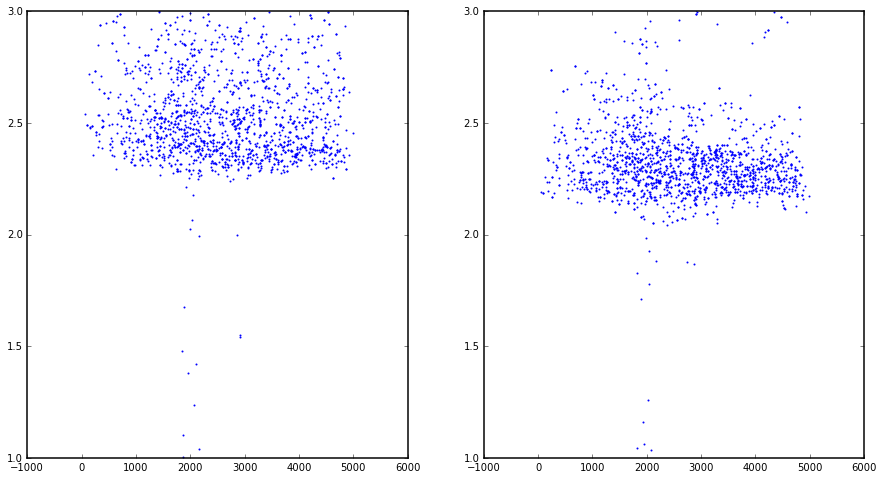

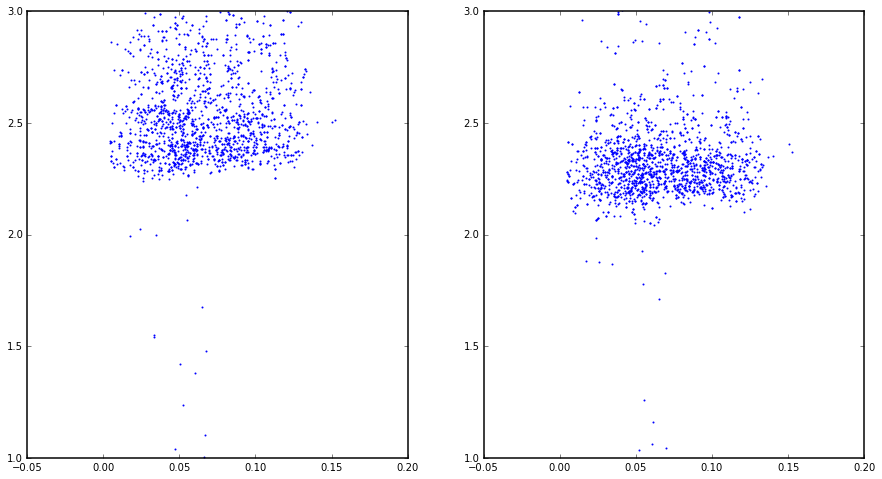

In [63]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'bold',
        'size'   : 25,
        }

plt.rcParams['axes.linewidth'] = 1.5 #set the value globally

r = np.sqrt(np.asarray(x)*np.asarray(x)+np.asarray(y)*np.asarray(y))

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 8))
ax0.scatter(r, np.asarray(xx), s=1, color="b")
ax1.scatter(r, np.asarray(yy), s=1, color="b")
ax0.set_ylim([1., 3.])
ax1.set_ylim ([1., 3.])

icr = np.sqrt(np.asarray(icX)*np.asarray(icX)+np.asarray(icY)*np.asarray(icY))
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 8))
ax0.scatter(icr, np.asarray(xx), s=1, color="b")
ax1.scatter(icr, np.asarray(yy), s=1, color="b")
ax0.set_ylim([1., 3.])
ax1.set_ylim ([1., 3.])

In [65]:
x = []
y = []
xx = []
yy = []
mag = []
icX = []
icY = []
ra = []
dec = []

for ccd in range(36) :
    dataid = {'visit':visit, 'filter':filter, 'ccd':ccd}

    # Retrieve src
    src = butler.get('src', dataid)
    # Retrieve metadata and calib
    md = butler.get("calexp_md", dataid)
    calib = afwImage.Calib(md)
    tanwcs = afwImage.TanWcs.cast(afwImage.makeWcs(md))
    
    if ccd == 0 :
        schema = src.getSchema()
        extKey = schema["base_ClassificationExtendedness_value"].asKey()
        extFlagKey = schema["base_ClassificationExtendedness_flag"].asKey()
        fluxFlagKey = schema["base_CircularApertureFlux_6_0_flag"].asKey()
        fluxKey = schema["base_CircularApertureFlux_6_0_flux"].asKey()
        fluxSigmaKey = schema["base_CircularApertureFlux_6_0_fluxSigma"].asKey()
        xxKey = schema["base_SdssShape_xx"].asKey()
        yyKey = schema["base_SdssShape_yy"].asKey()
        raKey = schema["coord_ra"].asKey()
        decKey = schema["coord_dec"].asKey()
        
    tmpx = []
    tmpy = []
    tmpxx = []
    tmpyy = []
    tmpmag = []
    tmpra = []
    tmpdec = []
        
    for s in src :
        if s.get(extFlagKey) or s.get(fluxFlagKey) or s.get(extKey) > 0.5 :
            continue
        
        flux = s.get(fluxKey)
        fluxSigma = s.get(fluxSigmaKey)
        
        if flux < 0 or flux / fluxSigma < 10 :
            continue
            
        m = calib.getMagnitude(flux)
        if m > 21 :
            continue
            
        tmpmag.append(m)
        tmpxx.append(s.get(xxKey))
        tmpyy.append(s.get(yyKey))
        tmpx.append(s.getX())
        tmpy.append(s.getY())
        tmpra.append(s.get(raKey)*180./3.14159)
        tmpdec.append(s.get(decKey)*180./3.14159)
        
#        iwc = tanwcs.skyToIntermediateWorldCoord(s.getCoord())
#        icX.append(iwc.getX())
#        icY.append(iwc.getY())

    mag.append(tmpmag)
    x.append(tmpx)
    y.append(tmpy)
    xx.append(tmpxx)
    yy.append(tmpyy)
    ra.append(tmpra)
    dec.append(tmpdec)
    
print len(xx)

36


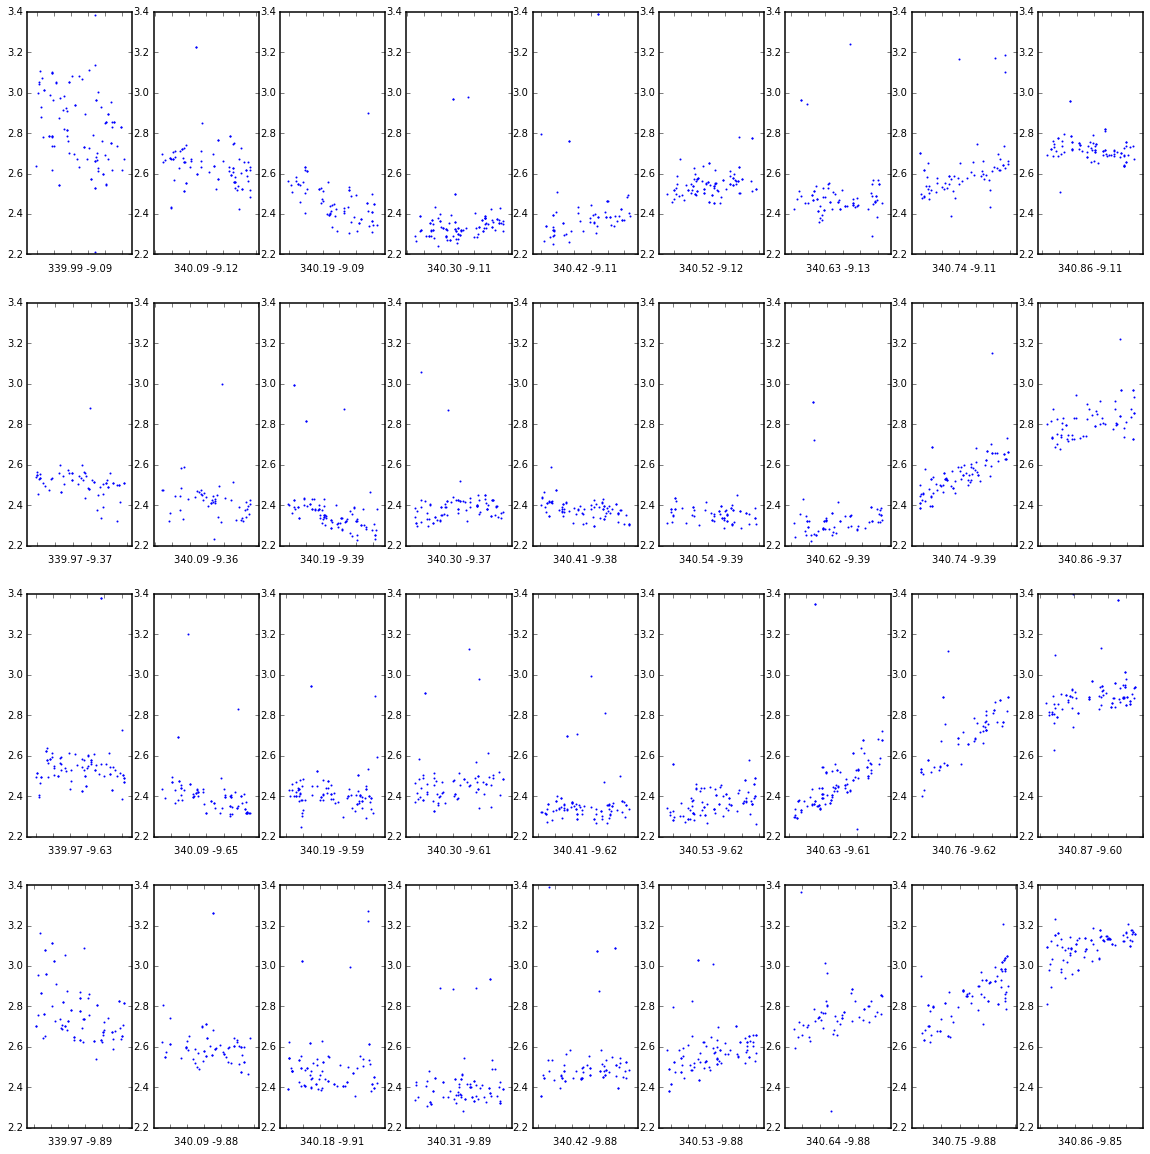

In [69]:
fig, (ax0) = plt.subplots(nrows=4, ncols=9, figsize=(20,20))

for i in range(4) :
    for j in range(9) :
        Min = float(min(ra[i*9+j]))-0.01
        Max = float(max(ra[i*9+j]))+0.01
        Ra = float(np.median(ra[i*9+j]))
        Dec = float(np.median(dec[i*9+j]))
        strRa = '%.2f ' % (Ra)
        strDec = '%.2f' % (Dec)
    
        ax0[i,8-j].scatter(ra[i*9+j], xx[i*9+j], s=1, color='b')
        ax0[i,8-j].set_ylim([2.2, 3.4])
        ax0[i,8-j].set_xlim([Min, Max])
        ax0[i,8-j].set_xlabel(strRa + strDec)
        ax0[i,8-j].axes.get_xaxis().set_ticklabels([])


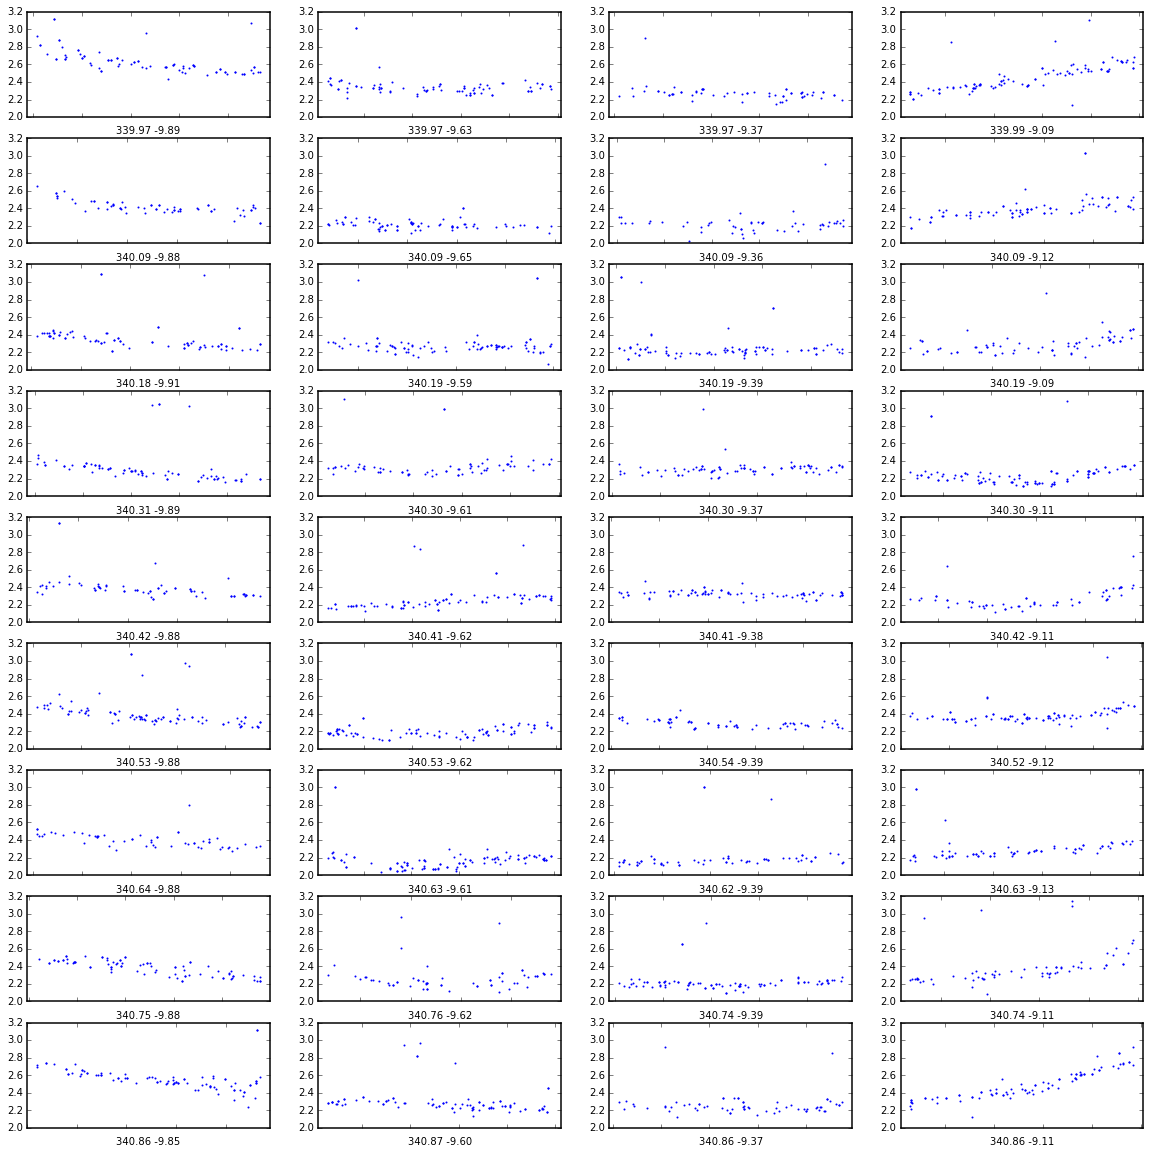

In [76]:
fig, (ax0) = plt.subplots(nrows=9, ncols=4, figsize=(20,20))

for i in range(4) :
    for j in range(9) :
        Min = float(min(dec[i*9+j]))-0.01
        Max = float(max(dec[i*9+j]))+0.01
        Ra = float(np.median(ra[i*9+j]))
        Dec = float(np.median(dec[i*9+j]))
        strRa = '%.2f ' % (Ra)
        strDec = '%.2f' % (Dec)
    
        ax0[8-j,3-i].scatter(dec[i*9+j], yy[i*9+j], s=1, color='b')
        ax0[8-j,3-i].set_ylim([2.0, 3.2])
        ax0[8-j,3-i].set_xlim([Min, Max])
        ax0[8-j,3-i].set_xlabel(strRa + strDec)
        ax0[8-j,3-i].axes.get_xaxis().set_ticklabels([])


In [48]:
print schema.getOrderedNames()

('id', 'coord_ra', 'coord_dec', 'parent', 'calib_detected', 'calib_psfCandidate', 'calib_psfUsed', 'calib_psfReserved', 'flags_negative', 'deblend_nChild', 'deblend_deblendedAsPsf', 'deblend_psfCenter_x', 'deblend_psfCenter_y', 'deblend_psfFlux', 'deblend_tooManyPeaks', 'deblend_parentTooBig', 'deblend_masked', 'deblend_skipped', 'deblend_rampedTemplate', 'deblend_patchedTemplate', 'deblend_hasStrayFlux', 'base_GaussianCentroid_x', 'base_GaussianCentroid_y', 'base_GaussianCentroid_flag', 'base_GaussianCentroid_flag_noPeak', 'base_NaiveCentroid_x', 'base_NaiveCentroid_y', 'base_NaiveCentroid_flag', 'base_NaiveCentroid_flag_noCounts', 'base_NaiveCentroid_flag_edge', 'base_SdssCentroid_x', 'base_SdssCentroid_y', 'base_SdssCentroid_xSigma', 'base_SdssCentroid_ySigma', 'base_SdssCentroid_flag', 'base_SdssCentroid_flag_edge', 'base_SdssCentroid_flag_noSecondDerivative', 'base_SdssCentroid_flag_almostNoSecondDerivative', 'base_SdssCentroid_flag_notAtMaximum', 'base_SdssShape_xx', 'base_SdssSh

In [11]:
x = []
y = []
xx = []
yy = []
mag = []
icX = []
icY = []
ra = []
dec = []
tmpxx = []
tmpra = []

for ccd in range(36) :
    dataid = {'visit':visit, 'filter':filter, 'ccd':ccd}

    # Retrieve src
    src = butler.get('src', dataid)
    # Retrieve metadata and calib
    md = butler.get("calexp_md", dataid)
    calib = afwImage.Calib(md)
    tanwcs = afwImage.TanWcs.cast(afwImage.makeWcs(md))
    
    if ccd == 0 :
        schema = src.getSchema()
        extKey = schema["base_ClassificationExtendedness_value"].asKey()
        extFlagKey = schema["base_ClassificationExtendedness_flag"].asKey()
        fluxFlagKey = schema["base_CircularApertureFlux_6_0_flag"].asKey()
        fluxKey = schema["base_CircularApertureFlux_6_0_flux"].asKey()
        fluxSigmaKey = schema["base_CircularApertureFlux_6_0_fluxSigma"].asKey()
        xxKey = schema["base_SdssShape_xx"].asKey()
        yyKey = schema["base_SdssShape_yy"].asKey()
        raKey = schema["coord_ra"].asKey()
        decKey = schema["coord_dec"].asKey()
        
    for s in src :
        if s.get(extFlagKey) or s.get(fluxFlagKey) or s.get(extKey) > 0.5 :
            continue
        
        flux = s.get(fluxKey)
        fluxSigma = s.get(fluxSigmaKey)
        
        if flux < 0 or flux / fluxSigma < 10 :
            continue
            
        m = calib.getMagnitude(flux)
        if m > 21 :
            continue
            
        tmpxx.append(s.get(xxKey))
        tmpra.append(s.get(raKey)*180/3.14159)
        
    if (ccd+1)%9 == 0 :
        xx.append(tmpxx)
        ra.append(tmpra)
        tmpxx = []
        tmpra = []
        
print len(xx)

4


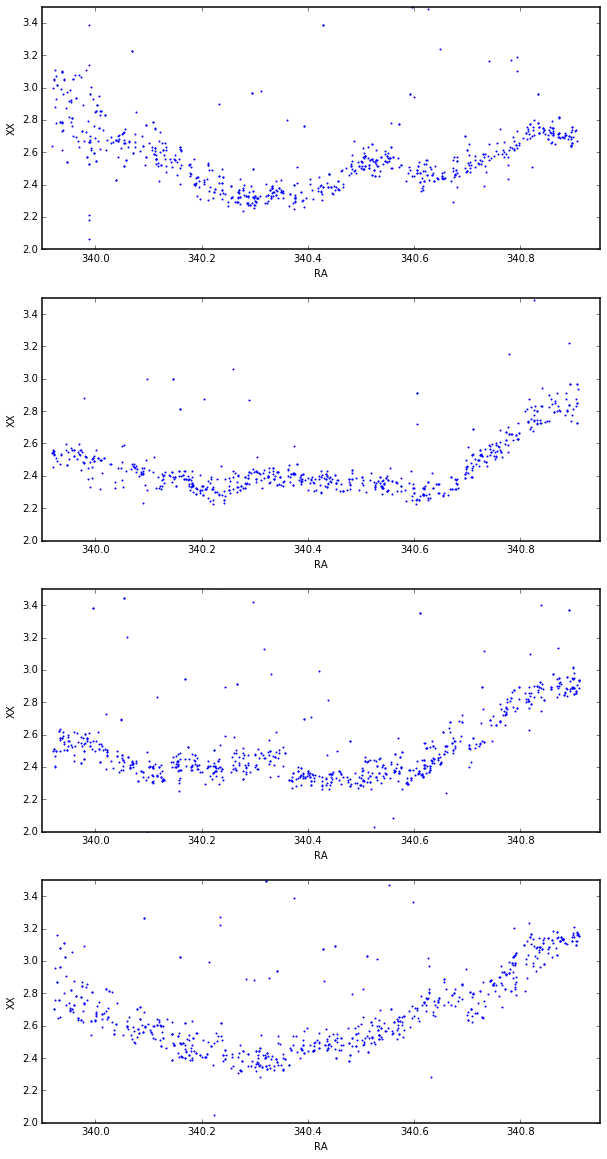

In [16]:
%matplotlib inline
import matplotlib
import matplotlib.pylab as plt
import numpy as np

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'bold',
        'size'   : 25,
        }

plt.rcParams['axes.linewidth'] = 1.5 #set the value globally

fig, (ax0) = plt.subplots(nrows=4, figsize=(10, 20))

for i in range(4) :
    ax0[i].scatter(ra[i], xx[i], s=1, color='b')
    ax0[i].set_xlim([339.9, 340.95])
    ax0[i].set_ylim([2, 3.5])
    ax0[i].set_xlabel("RA")
    ax0[i].set_ylabel("XX")
